# <center> <img src="../../labs/img/ITESOLogo.png" alt="ITESO" width="480" height="130"> </center>
# <center> **Departamento de Electrónica, Sistemas e Informática** </center>
---
### <center> **Procesamiento de Datos Masivos** </center>
---
### <center> **Primavera 2025** </center>
---
**Primer Examen**

**Fecha**: 14 de Marzo del 2025

**Nombre del estudiante**: Yochabel Martínez Cázares

**Professor**: Pablo Camarillo Ramirez

In [4]:
import findspark
findspark.init()

In [6]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("SparkSQL-Exam-1-Yochabel_Martínez_Cázares") \
    .master("spark://f04d2745dc57:7077") \
    .config("spark.ui.port","4040") \
    .getOrCreate()
sc = spark.sparkContext

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/03/14 13:31:17 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [ ]:
#Read the data
#Employees DataFrame
employees_df = spark \
                .read \
                .option("header", "true") \
                .csv("/home/jovyan/notebooks/data/employees.csv")
employees_df.printSchema()

#Departments DataFrame
departments_df = spark \
                .read \
                .option("inferSchema", "true") \
                .option("header", "true") \
                .csv("/home/jovyan/notebooks/data/departments.csv")
departments_df.printSchema()

root
 |-- employee_id: string (nullable = true)
 |-- employee_info: string (nullable = true)

root
 |-- department_id: integer (nullable = true)
 |-- department_name: string (nullable = true)
 |-- location: string (nullable = true)



In [ ]:
from pyspark.sql.functions import get_json_object

employees_df = employees_df.withColumn("employee", get_json_object(employees_df.employee_info, "$.employee")) \
    .withColumn("name", get_json_object(employees_df.employee_info, "$.name")) \
    .withColumn("department_id", get_json_object(employees_df.employee_info, "$.department_id").cast("integer")) \
    .withColumn("salary", get_json_object(employees_df.employee_info, "$.salary").cast("double")) \
    .withColumn("hire_date", get_json_object(employees_df.employee_info, "$.hire_date").cast("date"))

employees_df.select("name", "department_id", "salary", "hire_date").show()


+---------+-------------+---------+----------+
|     name|department_id|   salary| hire_date|
+---------+-------------+---------+----------+
|  Caitlyn|          103|115959.78|2002-06-10|
|   Rachel|          104|100820.16|2009-07-01|
|   Carrie|          105|114421.44|1998-12-10|
|    Renee|          104| 54688.13|1995-03-17|
|Gabriella|          109|106267.03|1995-02-09|
|  Kristen|          101| 88237.54|2010-11-15|
| Jonathan|          102| 39323.42|2012-06-30|
| Michelle|          101| 64262.85|2005-10-30|
| Michelle|          105|103521.88|1991-07-10|
|     Lisa|          110| 55435.93|2016-03-25|
|   Cheryl|          103| 88073.75|2020-08-21|
|  Mikayla|          107| 95192.05|2022-05-13|
|     Lisa|          104| 36032.49|2019-05-16|
|     Sean|          108| 64904.69|2021-06-06|
|   Monica|          105| 92589.97|2022-05-09|
|  Katelyn|          104|147225.58|2008-03-14|
|    Linda|          108|146632.64|2002-09-04|
|    Tammy|          109| 128860.4|2014-04-18|
|  William|  

In [35]:
#Join Operations
employees_enrich_df = employees_df.join(departments_df, employees_df["department_id"] == departments_df["department_id"], "left")
employees_enrich_df.show()

+-----------+--------------------+--------+---------+-------------+---------+----------+-------------+--------------------+-------------+
|employee_id|       employee_info|employee|     name|department_id|   salary| hire_date|department_id|     department_name|     location|
+-----------+--------------------+--------+---------+-------------+---------+----------+-------------+--------------------+-------------+
|          1|{'name': 'Caitlyn...|    NULL|  Caitlyn|          103|115959.78|2002-06-10|          103| Sales and Marketing|      Chicago|
|          2|{'name': 'Rachel'...|    NULL|   Rachel|          104|100820.16|2009-07-01|          104|    Data Engineering|      Zapopan|
|          3|{'name': 'Carrie'...|    NULL|   Carrie|          105|114421.44|1998-12-10|          105|        Data Science|      Seattle|
|          4|{'name': 'Renee',...|    NULL|    Renee|          104| 54688.13|1995-03-17|          104|    Data Engineering|      Zapopan|
|          5|{'name': 'Gabriel...|

In [44]:
#Transformations (Using when()) 
from pyspark.sql.functions import when, col
transformation_employees_df = employees_enrich_df.withColumn("salary_category",when(col("salary") >= 55000, "High").otherwise("Low"))
transformation_employees_df.show()

+-----------+--------------------+--------+---------+-------------+---------+----------+-------------+--------------------+-------------+---------------+
|employee_id|       employee_info|employee|     name|department_id|   salary| hire_date|department_id|     department_name|     location|salary_category|
+-----------+--------------------+--------+---------+-------------+---------+----------+-------------+--------------------+-------------+---------------+
|          1|{'name': 'Caitlyn...|    NULL|  Caitlyn|          103|115959.78|2002-06-10|          103| Sales and Marketing|      Chicago|           High|
|          2|{'name': 'Rachel'...|    NULL|   Rachel|          104|100820.16|2009-07-01|          104|    Data Engineering|      Zapopan|           High|
|          3|{'name': 'Carrie'...|    NULL|   Carrie|          105|114421.44|1998-12-10|          105|        Data Science|      Seattle|           High|
|          4|{'name': 'Renee',...|    NULL|    Renee|          104| 54688.13

In [49]:
#Filter and Group
high_salary_df = transformation_employees_df.filter(col("salary_category") == "High")
low_salary_df = transformation_employees_df.filter(col("salary_category") == "Low")

high_salary_df.show()
low_salary_df.show()

+-----------+--------------------+--------+---------+-------------+---------+----------+-------------+--------------------+-------------+---------------+
|employee_id|       employee_info|employee|     name|department_id|   salary| hire_date|department_id|     department_name|     location|salary_category|
+-----------+--------------------+--------+---------+-------------+---------+----------+-------------+--------------------+-------------+---------------+
|          1|{'name': 'Caitlyn...|    NULL|  Caitlyn|          103|115959.78|2002-06-10|          103| Sales and Marketing|      Chicago|           High|
|          2|{'name': 'Rachel'...|    NULL|   Rachel|          104|100820.16|2009-07-01|          104|    Data Engineering|      Zapopan|           High|
|          3|{'name': 'Carrie'...|    NULL|   Carrie|          105|114421.44|1998-12-10|          105|        Data Science|      Seattle|           High|
|          5|{'name': 'Gabriel...|    NULL|Gabriella|          109|106267.03

In [50]:
#Calculate the average salary per department for the two newly created data frames, which contain the salaries of employees categorized as “High” and “Low.”
#Resulting data frame for this transformation should contain only department_name and avg_salary columns
from pyspark.sql.functions import avg
high_avg_salary = high_salary_df.groupBy("department_name").agg(avg("salary").alias("avg_salary"))
low_avg_salary = low_salary_df.groupBy("department_name").agg(avg("salary").alias("avg_salary"))

high_avg_salary.show()
low_avg_salary.show()

+--------------------+------------------+
|     department_name|        avg_salary|
+--------------------+------------------+
|Corporate Strateg...|102741.38324414717|
| Sales and Marketing|100839.65275449108|
|    Data Engineering|101626.29492163012|
|Research and Deve...|  98714.3003086419|
|Finance and Accou...|100731.07877887784|
|    Customer Service|101585.01600000002|
|               Legal|  99366.3129102167|
|        Data Science|101903.63710344829|
|          Operations|100169.65621722837|
|     Human Resources|104999.43191489363|
+--------------------+------------------+



+--------------------+------------------+
|     department_name|        avg_salary|
+--------------------+------------------+
|Corporate Strateg...|41590.741833333326|
| Sales and Marketing| 41150.40277777778|
|    Data Engineering| 41358.50794117647|
|Finance and Accou...|42740.952888888874|
|Research and Deve...| 41426.43521126761|
|    Customer Service|42644.472021276604|
|               Legal| 41160.26616438357|
|        Data Science| 41974.18958333334|
|          Operations|40646.100705882345|
|     Human Resources| 41751.64784810126|
+--------------------+------------------+



In [51]:
#Sort 
#Find the Top 5 employees with highest salaries from employees categorized as “High”
high_salary_top5 = high_salary_df.orderBy(col("salary").desc())
#Find the Top 5 employees with highest salaries from employees categorized as “Low”
low_salary_top5 = low_salary_df.orderBy(col("salary").desc())

high_salary_top5.show(5)
low_salary_top5.show(5)

+-----------+--------------------+--------+---------+-------------+---------+----------+-------------+--------------------+-----------+---------------+
|employee_id|       employee_info|employee|     name|department_id|   salary| hire_date|department_id|     department_name|   location|salary_category|
+-----------+--------------------+--------+---------+-------------+---------+----------+-------------+--------------------+-----------+---------------+
|       1778|{'name': 'Gabriel...|    NULL|Gabriella|          101|149989.73|2018-09-14|          101|     Human Resources|  San Diego|           High|
|       3621|{'name': 'Katheri...|    NULL|Katherine|          101| 149979.3|2017-07-26|          101|     Human Resources|  San Diego|           High|
|        346|{'name': 'Ryan', ...|    NULL|     Ryan|          110| 149963.1|1990-07-03|          110|Corporate Strateg...|Los Angeles|           High|
|       3807|{'name': 'Caitlyn...|    NULL|  Caitlyn|          107|149956.54|2000-07-27|

In [63]:
#Find the number of employees with more years in the company
from pyspark.sql.functions import year, current_date
employees_enrich_df = employees_enrich_df.withColumn("years_in_the_company",year(current_date()) - year(col("hire_date")))
count = employees_enrich_df.groupBy("years_in_the_company").count().orderBy(col("years_in_the_company"))
count.show()


+--------------------+-----+
|years_in_the_company|count|
+--------------------+-----+
|                   0|   25|
|                   1|  102|
|                   2|  105|
|                   3|  114|
|                   4|  104|
|                   5|  113|
|                   6|   84|
|                   7|  119|
|                   8|   95|
|                   9|  112|
|                  10|  115|
|                  11|  101|
|                  12|  103|
|                  13|  105|
|                  14|  117|
|                  15|   96|
|                  16|  104|
|                  17|  106|
|                  18|  107|
|                  19|   97|
+--------------------+-----+
only showing top 20 rows



Display the  Spark Plan

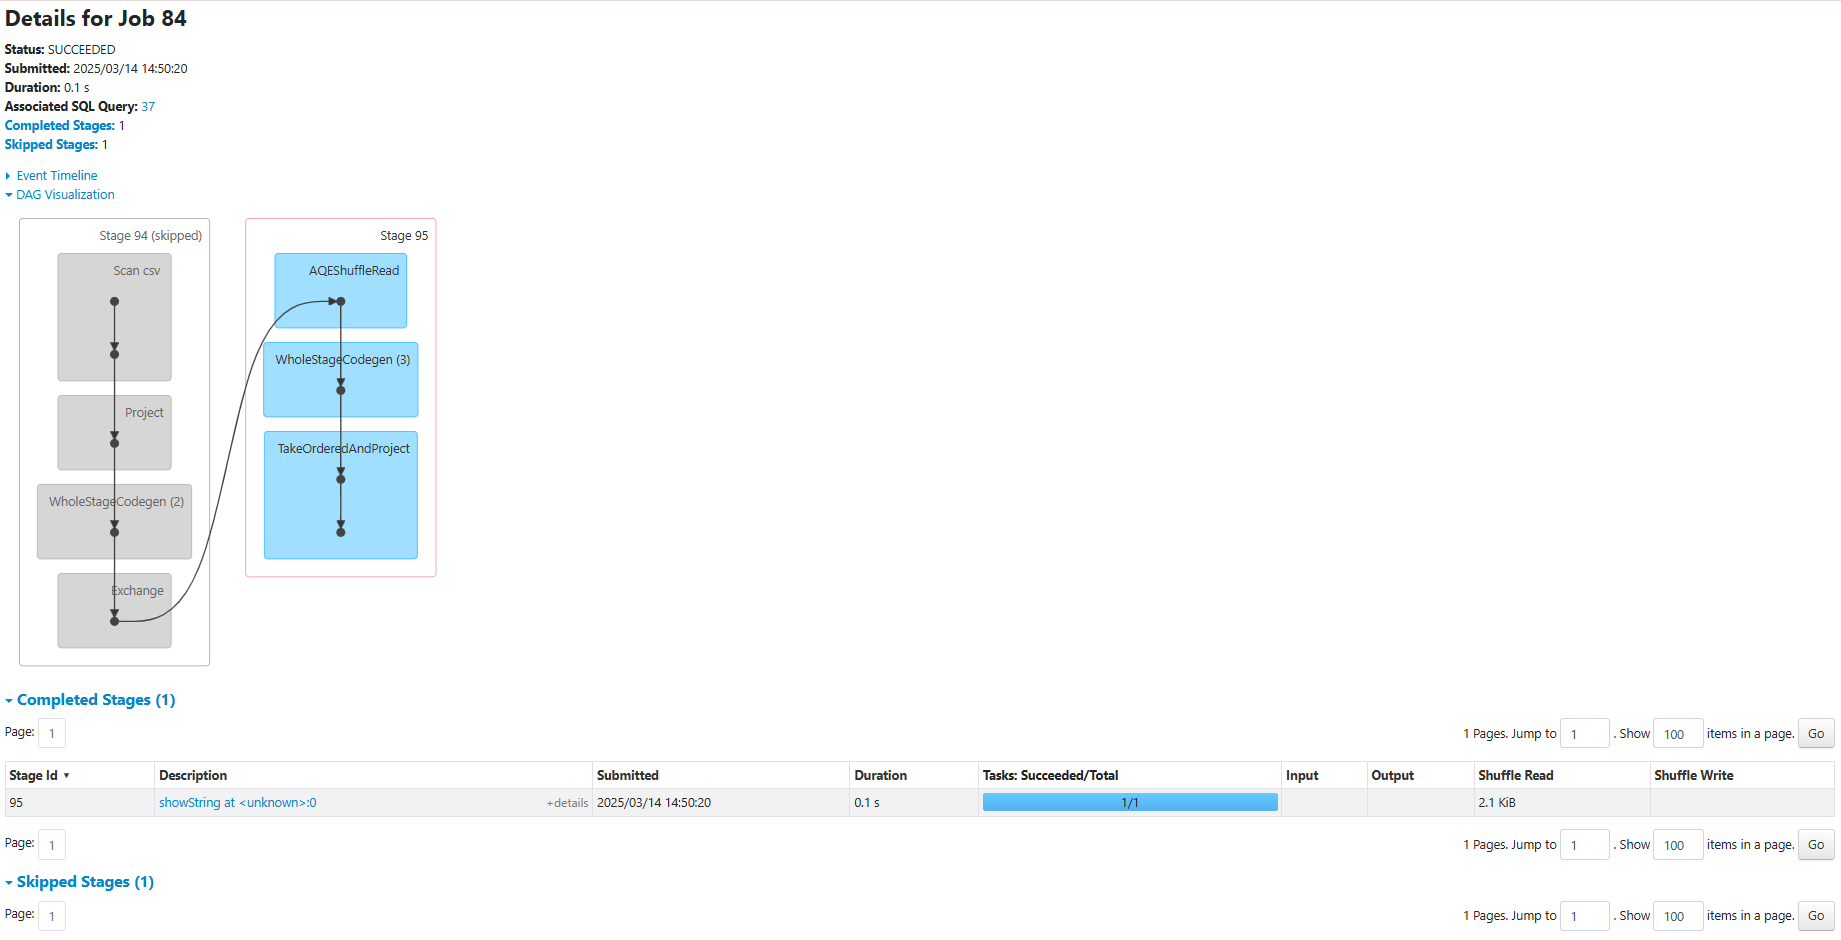